# Analysis

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# viz
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres"
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db"

In [3]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# INSPECT
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(12)
last_name VARCHAR(13)
email VARCHAR(42)

campaign
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(33)
description VARCHAR(53)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launch_date DATE
end_date DATE
category_id VARCHAR(4)
subcategory_id VARCHAR(8)

category
category_id VARCHAR(4)
category VARCHAR(12)

subcategory
subcategory_id VARCHAR(8)
subcategory VARCHAR(17)



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['contacts', 'campaign', 'category', 'subcategory']

In [6]:
# Assign the classes to variables
Camp = Base.classes.campaign
subCat = Base.classes.subcategory
Co = Base.classes.contacts
Cat = Base.classes.category

# Questions

# Question 1: What crowdfunding campaign category is most successful? (Bar Plot)

In [7]:
# step 1: select categories from the category table 
# step 2: select outcomes from the campaign table 
# step 3: select category id from category & campaign tables 
# step 3: Plot the data 

In [17]:
query = """
    SELECT
        campaign.outcome,
        category.category
    FROM
        campaign
    INNER JOIN
        category
    ON
        category.category_id=campaign.category_id
    ;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,outcome,category
0,failed,food
1,successful,music
2,successful,technology
3,failed,music
4,failed,theater


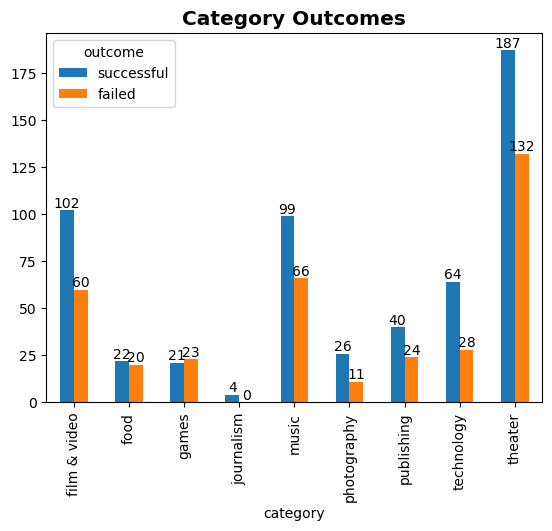

In [18]:
# plot data 

pg = df.groupby(["category", "outcome"])["category"].count().unstack("outcome")
ax = pg[["successful","failed"]].plot(kind="bar")
plt.title("Category Outcomes", fontweight="bold", fontsize=14.5)
for container in ax.containers:
    ax.bar_label(container, size=10)



# Question #2: What is the relationship between the backers count and the amount pledged in USD (Regression)

In [10]:
query = """
    SELECT
        backers_count,
        pledged,
        currency
    FROM
        campaign
    WHERE currency='USD'
    ;
"""
df = pd.read_sql(text(query), con=engine)
df.head()

,backers_count,pledged,currency
0,158,14560.0,USD
1,24,2477.0,USD
2,53,5265.0,USD
3,44,3208.0,USD
4,220,13838.0,USD


y = 41.89x + 11218.62
The r-squared is: 0.7496992378033811


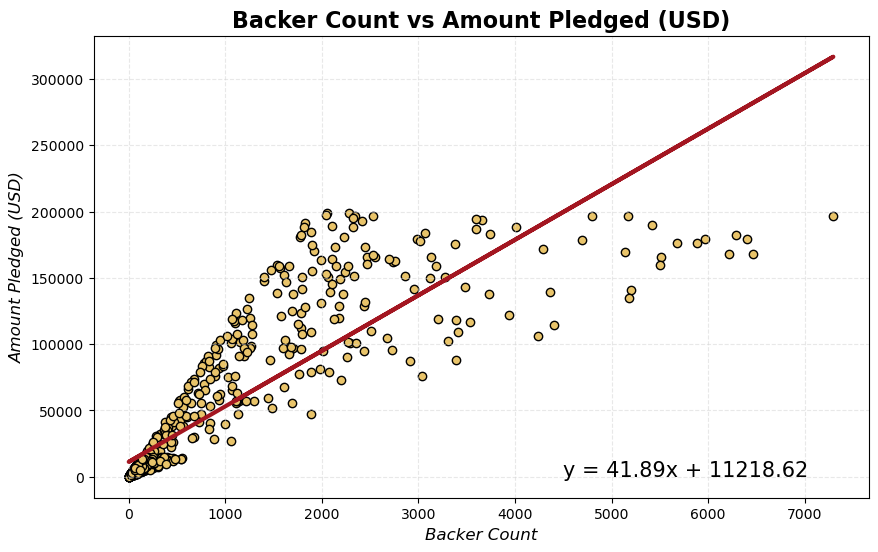

In [11]:
# plot data

x_values = df.backers_count
y_values = df.pledged

# makes the line of best fit
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# make the plot
# Step 2: Make the canvas
plt.figure(figsize=(10, 6))

# Step 3: Make the basic plot
plt.scatter(x_values, y_values, facecolor="#e9c46a", edgecolor="black")
plt.plot(x_values, regress_values, "#A31621", linewidth=3)

# Step 4: Customizations
plt.xlabel("Backer Count", fontsize=12, fontstyle="italic")
plt.ylabel("Amount Pledged (USD)", fontsize=12, fontstyle="italic")
plt.title("Backer Count vs Amount Pledged (USD)", fontweight="bold", fontsize=16)
plt.grid(color="lightgrey", linestyle = "--", alpha=0.5)


plt.annotate(line_eq,(4500, 100),fontsize=15,color="black")

print(f"The r-squared is: {rvalue**2}")
plt.show()

# Question #3: What is the relation of the outcomes based on goal amounts in USD. (split violin plot)


In [12]:
query = """
    SELECT
        outcome,
        goal
    FROM
        campaign
    WHERE currency='USD'
        AND outcome IN ('successful', 'failed')
    ;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,outcome,goal
0,successful,1400.0
1,failed,4200.0
2,failed,7600.0
3,failed,6200.0
4,successful,5200.0


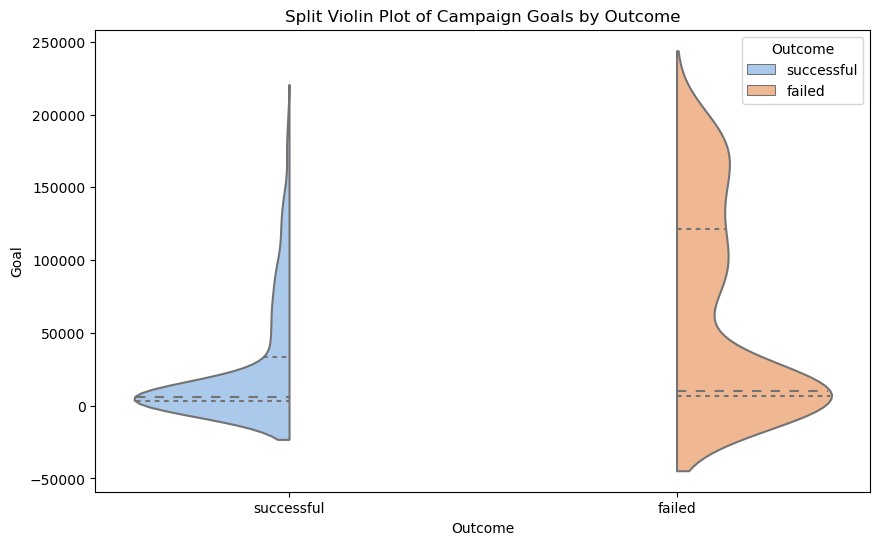

In [15]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='outcome', y='goal', data=df, hue='outcome', split=True, inner="quartile", palette='pastel')
plt.title('Split Violin Plot of Campaign Goals by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Goal')
plt.legend(title='Outcome', loc='upper right')
plt.show()